# Annotate experiments
Notebook used to create binary annotations for experiments using a computer vision approach, or deep networks.  
Manual tuning and correction are used to improve the quality of the detection, before it is used as ground truths.

In [1]:
%matplotlib inline

import os, sys, time, shutil, copy
import warnings
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io, filters, measure, external
from skimage import morphology as morph
from skimage.morphology import disk

import torch

# Add parent folder to path in order to access `axoid`
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from axoid.utils.image import imread_to_float, to_npint, overlay_contours
from axoid.utils.processing import nlm_denoising
from axoid.utils.ccreg import register_stack
from axoid.utils.script import Arguments
from axoid.detection.cv.detector import cv_detect
from axoid.detection.deeplearning.data import normalize_range, pad_transform_stack, compute_weights
from axoid.detection.deeplearning.finetuning import fine_tune
from axoid.detection.deeplearning.test import predict_stack
# from deep_learning import generate_weights # DEAL WITH WEIGHTS
from axoid.tracking.model import InternalModel

%load_ext autoreload
%autoreload 2

### Load experiment

In [6]:
animal_to_annotate = os.listdir("/data/talabot/experiments/to_annotate/")
animal_annotated = os.listdir("/data/talabot/experiments/annotated/")

# Randomly select an animal without any annotated experiment
animal = np.random.choice([animal for animal in animal_to_annotate if animal not in animal_annotated])
# Randomly select an experiment to annotated
experiment = np.random.choice(os.listdir(os.path.join("/data/talabot/experiments/to_annotate/", animal)))

animal = "SS25451_20180822_tdTomGC6fopt-fly3"
experiment = "SS25451_20180822_tdTomGC6fopt-fly3_001"
print(animal, experiment, sep="\n")

SS25451_20180822_tdTomGC6fopt-fly3
SS25451_20180822_tdTomGC6fopt-fly3_001


In [7]:
# Load RGB stack and register it
rgb_stack = imread_to_float(os.path.join("/data/talabot/experiments/to_annotate/", animal, experiment, "RGB.tif"))
reg_rgb = register_stack(rgb_stack, ref_num=1)

@interact(image=(0, len(rgb_stack) - 1))
def plot_stack(image=0):
    plt.figure(figsize=(10,6))
    plt.suptitle("Animal: %s\nExp: %s" % (animal, experiment))
    plt.subplot(121)
    plt.title("Raw frame %d" % image)
    plt.imshow(rgb_stack[image])
    plt.subplot(122)
    plt.title("Mean temporal registered image")
    plt.imshow(reg_rgb.mean(0))
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=567), Output()), _dom_classes=('widget-inter…

# Computer Vision detector

In [8]:
# Test the denoising and detector to tune their parameters
print("Denoising")
@interact(image=(0, len(rgb_stack) - 1),
          h_red=widgets.BoundedIntText(value=11, min=0),
          h_green=widgets.BoundedIntText(value=11, min=0))
def plot_denoising(image=0, h_red=11, h_green=11):
    start = time.time()
    denoised = nlm_denoising(rgb_stack, img_id=image, h_red=h_red, h_green=h_green)
    duration = time.time() - start
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(122)
    plt.title("Denoised\n(Took %f s.)" % duration)
    plt.imshow(denoised)
    plt.tight_layout()
    plt.show()

print("Detection")
@interact(image=(2, len(rgb_stack) - 3),
          h_red=widgets.BoundedIntText(value=11, min=0),
          h_green=widgets.BoundedIntText(value=11, min=0),
          sigma_gauss=widgets.BoundedFloatText(value=2, min=0, max=5, step=0.1),
          thresh_fn=widgets.ToggleButtons(options=["Otsu", "Li", "Constant"]),
          thresh_val=widgets.BoundedIntText(value=30, min=0, max=255),
          erosion=(0,5))
def plot_detector(image=0, h_red=11, h_green=11, sigma_gauss=2, thresh_fn="Otsu", thresh_val=30, erosion=0):
    if thresh_fn == "Otsu":
        thresholding_fn = filters.threshold_otsu
    elif thresh_fn == "Li":
        thresholding_fn = filters.threshold_li
    elif thresh_fn == "Constant":
        thresholding_fn = lambda x: thresh_val / 255
    
    denoised = nlm_denoising(rgb_stack, img_id=image, h_red=h_red, h_green=h_green)
    start = time.time()
    detection = cv_detect(rgb_stack[image - 2: image + 3], 
                          h_red=h_red, h_green=h_green,
                          sigma_gauss=sigma_gauss,
                          thresholding_fn=thresholding_fn, 
                          registration=False, selem=disk(erosion))[2]
    duration = time.time() - start
    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(222)
    plt.title("Denoised")
    plt.imshow(denoised)
    plt.subplot(223)
    plt.title("Detection\n(Took %f s.)" % duration)
    plt.imshow(detection)
    plt.subplot(224)
    plt.title("Detection contours")
    plt.imshow(overlay_contours(rgb_stack[image], detection))
    plt.tight_layout()
    plt.show()

Denoising


interactive(children=(IntSlider(value=0, description='image', max=567), BoundedIntText(value=11, description='…

Detection


interactive(children=(IntSlider(value=2, description='image', max=565, min=2), BoundedIntText(value=11, descri…

In [5]:
# Apply detector to the whole stack (/!\ a bit slow)
h_red = 42
h_green = 40
sigma_gauss = 0.8
thresholding_fn = filters.threshold_otsu
erosion = 0

start = time.time()
cv_detection = cv_detect(rgb_stack, h_red=h_red, h_green=h_green, sigma_gauss=sigma_gauss,
                         thresholding_fn=thresholding_fn, registration=False, selem=disk(erosion))
duration = time.time() - start
duration_str = "%d min %d s" % (duration // 60, duration % 60)
print("CV detection took %s." % duration_str)

@interact(image=(0, len(cv_detection) - 1))
def plot_detector(image=0):
    plt.figure(figsize=(13,5))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Detection")
    plt.imshow(cv_detection[image])
    plt.subplot(133)
    plt.title("Detection contours")
    plt.imshow(overlay_contours(rgb_stack[image], cv_detection[image]))
    plt.tight_layout()
    plt.show()

CV detection took 6 min 27 s.


interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

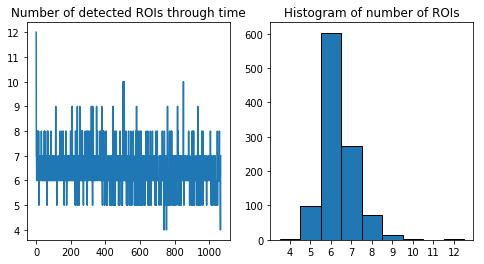

In [6]:
# Plot number of detected ROIs along time
num_roi = np.zeros(len(cv_detection))
for i in range(len(num_roi)):
    num_roi[i] = measure.label(cv_detection[i], connectivity=1, return_num=True)[1]
#     if num_roi[i] != 2:
#         print(i, num_roi[i])

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(num_roi)
plt.yticks(np.arange(num_roi.min(), num_roi.max() + 1))
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(num_roi, bins=np.arange(num_roi.min(), num_roi.max() + 2), align='left', edgecolor='k')
plt.xticks(np.arange(num_roi.min(), num_roi.max() + 1))
plt.show()

# Deep learning detector

In [9]:
model_name = "190401_sep_synth_aug"
# model_name = "RG_synth_only_190311"
# model_name = "unet4-16_RG_cv-annotated_aug"
# model_name = "unet4-16_synth_only_2-6neur_181205"
# model_name = "R_synth_only_181205_pixel-weight"

input_channels = "RG"
model_dir = "deep_learning/models/"
u_depth = 4
out1_channels = 16
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load model
sys.path.append(os.path.join(model_dir, model_name))
from utils_model_save import CustomUNet as ModelNet

model = ModelNet(len(input_channels), u_depth=u_depth, out1_channels=out1_channels, batchnorm=True, device=device)
model.load_state_dict(torch.load(os.path.join(model_dir, model_name, "model_best.pth")))
model.eval()

# Predict
transform = lambda stack: normalize_range(pad_transform_stack(stack, u_depth))
start = time.time()
predictions = predict_stack(model, rgb_stack, batch_size, input_channels=input_channels, 
                            numpy_channels_last=True, transform=transform)
print("Prediction took %.1f s." % (time.time() - start))
predictions = torch.sigmoid(predictions).numpy()

# Display results
@interact(image=(0, len(rgb_stack) - 1),
          detection_th=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, readout_format=".1f"))
def plot_detector(image=0, detection_th=0.5):
    detection = predictions[image] > detection_th
    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(222)
    plt.title("Detection contours")
    plt.imshow(overlay_contours(rgb_stack[image], detection, rescale_img=True))
    plt.subplot(223)
    plt.title("Prediction probabilities")
    plt.imshow(predictions[image])
    plt.subplot(224)
    plt.title("Detection")
    plt.imshow(detection)
    plt.tight_layout()
    plt.show()

Device: cuda:0
Prediction took 1.9 s.


interactive(children=(IntSlider(value=0, description='image', max=1066), FloatSlider(value=0.5, description='d…

In [10]:
# Make final predictions
dl_detection_th = 0.5

dl_detection = predictions > dl_detection_th
@interact(image=(0, len(rgb_stack) - 1))
def plot_detector(image=0):    
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(122)
    plt.title("Detection")
    plt.imshow(dl_detection[image])
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

### Fine tuning
Fine tune the deep network detector on manual annotations

In [13]:
# Indices of frames to use for fine tuning
idx_train = [274, 553, 919, 369, 1025]
idx_valid = [721, 747]

rgb_train = np.stack([rgb_stack[idx] for idx in idx_train])
rgb_valid = np.stack([rgb_stack[idx] for idx in idx_valid])

In [17]:
seg_annotated = external.tifffile.imread("/home/user/talabot/workdir/annotations.tif") / 255
seg_train = seg_annotated[:len(idx_train)]
seg_valid = seg_annotated[len(idx_train):]

In [19]:
# Add some prediction frames as annotations
new_idx_train = [928, 549, 420]
new_idx_valid = [120, 128, 738]

new_rgb_train = np.stack([rgb_stack[idx] for idx in new_idx_train])
new_rgb_valid = np.stack([rgb_stack[idx] for idx in new_idx_valid])
new_seg_train = np.stack([predictions[idx] > dl_detection_th for idx in new_idx_train])
new_seg_valid = np.stack([predictions[idx] > dl_detection_th for idx in new_idx_valid])
rgb_train = np.concatenate([rgb_train, new_rgb_train])
rgb_valid = np.concatenate([rgb_valid, new_rgb_valid])
seg_train = np.concatenate([seg_train, new_seg_train])
seg_valid = np.concatenate([seg_valid, new_seg_valid])

In [20]:
seg_train = seg_train.astype(rgb_train.dtype)
seg_valid = seg_valid.astype(rgb_valid.dtype)
weights_train = compute_weights(seg_train, contour=False, separation=True)
weights_valid = compute_weights(seg_valid, contour=False, separation=True)

start = time.time()
model_ft = fine_tune(model, rgb_train, seg_train, weights_train, rgb_valid, seg_valid, 
                     data_aug=True, n_iter_max=1000, patience=200, batch_size=16, learning_rate = 0.0005,
                     verbose=1)
print("\nFine tuning took %.1f s." % (time.time() - start))
last_model_ft = copy.deepcopy(model_ft)

Initial val_dice = 0.928071
Iteration (max 1000): 
50: dice = 0.850634 - val_dice = 0.865390
100: dice = 0.881978 - val_dice = 0.871272
150: dice = 0.912737 - val_dice = 0.885658
200: dice = 0.915950 - val_dice = 0.880693
250: dice = 0.941291 - val_dice = 0.892770
300: dice = 0.945954 - val_dice = 0.893664
350: dice = 0.937615 - val_dice = 0.887603
400: dice = 0.949817 - val_dice = 0.895448
450: dice = 0.953803 - val_dice = 0.885548
500: dice = 0.955601 - val_dice = 0.890841
550: dice = 0.964124 - val_dice = 0.888080
600: dice = 0.944301 - val_dice = 0.889026
200 iterations without validation improvements. Fine tuning is interrupted at iteration 610.
Best model fine tuned in iteration 410.

Fine tuning took 38.2 s.


NameError: name 'copy' is not defined

In [26]:
# Predict
start = time.time()
predictions_ft = predict_stack(model_ft, rgb_stack, batch_size, input_channels=input_channels, 
                               numpy_channels_last=True, transform=transform)
print("Prediction took %.1f s." % (time.time() - start))
predictions_ft = torch.sigmoid(predictions_ft).numpy()
ft_detection = predictions_ft > 0.5

# Display results
@interact(image=(0, len(rgb_stack) - 1),
          detection_th=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, readout_format=".1f"))
def plot_detector(image=0, detection_th=0.5):
    detection = predictions[image] > detection_th
    detection_ft = predictions_ft[image] > 0.5
    
    plt.figure(figsize=(13,8))
    plt.subplot(231)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(232)
    plt.title("Prediction probabilities")
    plt.imshow(predictions[image])
    plt.subplot(233)
    plt.title("Detection")
    plt.imshow(detection)
    plt.subplot(235)
    plt.title("Fine tuned probabilities")
    plt.imshow(predictions_ft[image])
    plt.subplot(236)
    plt.title("Fine tuned detection")
    plt.imshow(detection_ft)
    plt.tight_layout()
    plt.show()

Prediction took 1.9 s.


interactive(children=(IntSlider(value=0, description='image', max=1066), FloatSlider(value=0.5, description='d…

580


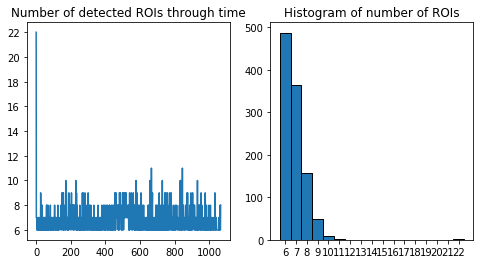

In [28]:
# Plot number of detected ROIs along time
num_roi = np.zeros(len(dl_detection))
for i in range(len(num_roi)):
    num_roi[i] = measure.label(ft_detection[i], connectivity=1, return_num=True)[1]
#     if num_roi[i] == 8:
#         print(i, num_roi[i])
print(np.sum(num_roi > 6))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(num_roi)
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(num_roi, bins=np.arange(num_roi.min(), num_roi.max() + 2), align='left', edgecolor='k')
plt.xticks(np.arange(num_roi.min(), num_roi.max() + 1))
plt.show()

# Select and tune best results
Compare results of detector, manually tune/correct them, etc.

In [30]:
cv_processed = np.zeros_like(cv_detection)
dl_processed = np.zeros_like(ft_detection)
for i in range(len(rgb_stack)):
    cv_processed[i] = morph.remove_small_objects(cv_detection[i], min_size=16)
    dl_processed[i] = morph.remove_small_objects(ft_detection[i], min_size=16)

@interact(image=(0, len(rgb_stack) - 1))
def plot_detector(image=0):    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(222)
    plt.title("Red input")
    plt.imshow(rgb_stack[image,...,0])
    plt.subplot(223)
    plt.title("CV processed")
    plt.imshow(cv_processed[image])
    plt.subplot(224)
    plt.title("DL processed")
    plt.imshow(dl_processed[image])
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

In [23]:
pre_processed = dl_processed.copy()
processed = pre_processed.copy()

# Plot number of detected ROIs along time
num_roi = np.zeros(len(processed))
for i in range(len(num_roi)):
    labels, num_roi[i] = measure.label(processed[i], connectivity=1, return_num=True)
    if (pre_processed[i] == identities[i].astype(processed2.dtype)).all():
        continue
    plt.figure(figsize=(10,5))
    plt.suptitle("Frame %d" % i)
    plt.subplot(121)
    plt.imshow(rgb_stack[i])
    plt.subplot(122)
    plt.imshow(labels)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    for region in measure.regionprops(labels):
        print(region.label, region.area)
    choice = input("Which to delete ? (0 for nothing): ")
    for c in choice.split(",")[0]:
        c = int(c)
        if c > 0:
            processed[i][labels == c] = 0
            print("Label %d is set to background." % c)
        else:
            print("Nothing is done.")
    # Label with more than one digit
    for c in choice.split(",")[1:]:
        c = int(c)
        if c > 0:
            processed[i][labels == c] = 0
            print("Label %d is set to background." % c)
        else:
            print("Nothing is done.")
    time.sleep(1)
    clear_output()

@interact(image=(0, len(rgb_stack) - 1))
def plot_detector(image=0):    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(222)
    plt.title("Red input")
    plt.imshow(rgb_stack[image,...,0])
    plt.subplot(223)
    plt.title("Before processing")
    plt.imshow(pre_processed[image])
    plt.subplot(224)
    plt.title("After processing")
    plt.imshow(processed[image])
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=567), Output()), _dom_classes=('widget-inter…

In [43]:
processed2 = np.zeros_like(processed)
for i in range(len(processed)):
    labels = measure.label(processed[i], connectivity=1)
    regions = measure.regionprops(labels)
    
    for region in regions:
        if region.area > 300:
            processed2[i] = np.maximum(processed2[i], morph.binary_erosion(labels == region.label, disk(2)))
        elif region.area > 150:
            processed2[i] = np.maximum(processed2[i], morph.binary_erosion(labels == region.label, disk(1)))
        else:
            processed2[i] = np.maximum(processed2[i], labels == region.label)

# Delete small elements created in the process
for i in range(len(processed2)):
    processed2[i] = morph.remove_small_objects(processed2[i], min_size=16)

@interact(image=(0, len(rgb_stack) - 1))
def plot_detector(image=0):    
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(222)
    plt.title("Overlay with after")
    plt.imshow(overlay_contours(rgb_stack[image], processed2[image], rescale_img=True))
    plt.subplot(223)
    plt.title("Before processing")
    plt.imshow(processed[image])
    plt.subplot(224)
    plt.title("After processing")
    plt.imshow(processed2[image])
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=649), Output()), _dom_classes=('widget-inter…

In [41]:
# Track to select subset of detection
init_idx = 567
n_update = 5
max_iter = 5
seg_stack = dl_processed.copy()
model = InternalModel(add_new_axons=False)
identities = np.zeros(seg_stack.shape, np.uint8)

start = time.time()
# Initialization
model.fit_normalization(rgb_stack, seg_stack)
model.initialize(rgb_stack[init_idx], measure.label(seg_stack[init_idx], connectivity=1))
# Iterate n_update time through the frames to udpate the model
for _ in range(n_update):
    for i in range(1, len(seg_stack)):
        identities[i] = model.match_frame(rgb_stack[i], seg_stack[i], time_idx=i, max_iter=max_iter)
        model.update_model(rgb_stack[i], identities[i], time_idx=i)
# Iterate a final time to finalize the identities (without updating the model)
for i in range(len(seg_stack)):
    identities[i] = model.match_frame(rgb_stack[i], seg_stack[i], time_idx=i, max_iter=max_iter)
print("Tracking took %d s." % (time.time() - start))

id_cmap = matplotlib.cm.get_cmap('viridis')
id_cmap.set_under([0,0,0])
@interact(image=(0, len(identities) - 1))
def plot_id(image=0):
    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.imshow(rgb_stack[image])
    plt.subplot(222)
    plt.imshow(seg_stack[image], cmap="gray")
    plt.subplot(223)
    plt.imshow(model.image, cmap=id_cmap, vmin=1)
    plt.subplot(224)
    plt.imshow(identities[image], cmap=id_cmap, vmin=1, vmax=identities.max())
    plt.tight_layout()
    plt.show()

Tracking took 186 s.


interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

52


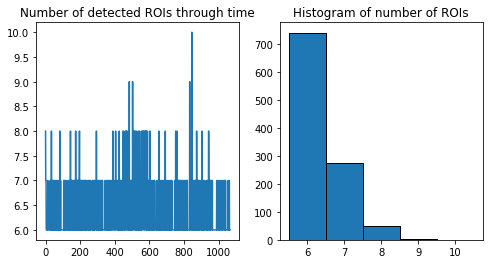

In [40]:
# Plot number of detected ROIs along time
num_roi = np.zeros(len(cv_processed))
for i in range(len(num_roi)):
    num_roi[i] = measure.label(dl_processed[i], connectivity=1, return_num=True)[1]
#     if num_roi[i] > 8:
#         print(i, num_roi[i])

print(np.sum(num_roi > 7))
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(num_roi)
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(num_roi, bins=np.arange(num_roi.min(), num_roi.max() + 2), align='left', edgecolor='k')
plt.xticks(np.arange(num_roi.min(), num_roi.max() + 1))
plt.show()

# Save final detection
Save the final detection as ground truths segmentation and move the corresponding experience folder to the annotated directory.

In [32]:
final_detection = processed

# Save as segmentation images
folder = os.path.join("/data/talabot/experiments/to_annotate/", animal, experiment)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Save full stacks
    io.imsave(os.path.join(folder, "seg_ROI.tif"), to_npint(final_detection))
    # Save image per image
    os.makedirs(os.path.join(folder, "seg_frames/"), exist_ok=True)
    for i in range(len(final_detection)):
        io.imsave(os.path.join(folder, "seg_frames", "seg_{:04}.png".format(i)), to_npint(final_detection[i]))

# Move the experiment to "annotated/" directory
os.makedirs(os.path.join("/data/talabot/experiments/to_annotate/", animal), exist_ok=True)
shutil.move(os.path.join("/data/talabot/experiments/to_annotate/", animal, experiment),
            os.path.join("/data/talabot/experiments/annotated/", animal, experiment))
print("Moved %s to 'annotated/'." % experiment)

# Make sure there is 'rgb_frames/'
if not os.path.isdir(os.path.join("/data/talabot/experiments/annotated/", animal, experiment, "rgb_frames/")):
    os.makedirs(os.path.join("/data/talabot/experiments/annotated/", animal, experiment, "rgb_frames/"))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i in range(len(rgb_stack)):
            io.imsave(os.path.join("/data/talabot/experiments/annotated/", animal, experiment, 
                                   "rgb_frames/", "rgb_{:04}.png".format(i)), to_npint(rgb_stack[i]))

# Generate weights for pixel-wise loss weighting
args = Arguments(data_dir=os.path.join("/data/talabot/experiments/annotated/", animal))
generate_weights.main(args)

Moved SS25451_20180824_fly1_007 to 'annotated/'.
Processing 
  1/1
